In [3]:
import numpy as np
import pandas as pd

data_path = "/bigdisk/data/dataset/CheXpert-v1.0-small"
train_df = pd.read_csv(data_path+'/train.csv')
val_df = pd.read_csv(data_path+'/valid.csv')

u_one_features = ['Atelectasis', 'Edema']
u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion', 'No Finding',
                   'Enlarged Cardiomediastinum', 'Lung Opacity', 'Lung Lesion', 'Pneumonia',
                  'Pneumothorax', 'Pleural Other', 'Support Devices']


chexnet_targets = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

chexpert_targets = ['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion', 'No Finding']

def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
    if len(feature_list) == 0:
        feature_list.append('')
            
    return feature_list

train_df['feature_string'] = train_df.apply(feature_string,axis = 1).fillna('')
val_df['feature_string'] = val_df.apply(feature_string,axis = 1).fillna('')

msk = np.random.rand(len(train_df)) < 0.4

small_train_df = train_df[~msk]

Counter({'Support Devices': 69593, 'Lung Opacity': 63416, 'Pleural Effusion': 51483, 'Atelectasis': 40251, 'Edema': 39142, 'Cardiomegaly': 16106, 'No Finding': 13485, 'Pneumothorax': 11616, 'Consolidation': 8886, 'Enlarged Cardiomediastinum': 6506, '': 6333, 'Lung Lesion': 5441, 'Pneumonia': 3583, 'Pleural Other': 2076}) ['No Finding', 'Support Devices', 'Lung Opacity', 'Edema', 'Pneumothorax', 'Atelectasis', 'Cardiomegaly', '', 'Pleural Effusion', 'Enlarged Cardiomediastinum', 'Consolidation', 'Pleural Other', 'Lung Lesion', 'Pneumonia']


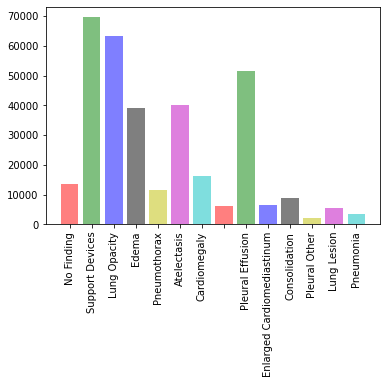

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

labels_count = Counter(label for chexpert_targets in small_train_df['feature_string'] for label in chexpert_targets)
print(labels_count, list(labels_count.keys()))
x_pos = np.arange(len(labels_count.values()))
lbls = list.copy(list(labels_count.keys()))

plt.bar(x_pos, labels_count.values(), align='center', alpha=0.5 , color=['r', 'g', 'b', 'k', 'y', 'm', 'c'])
plt.xticks(x_pos, lbls, rotation='vertical')
plt.show()

# Oversample Chexpert Classes

In [8]:
import tqdm

In [10]:
#oversampled_small_train_df
oversampled_small_train_df = small_train_df.copy()
print(len(oversampled_small_train_df))
y_labels = list(small_train_df['feature_string'])
targets = ['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
_to_oversample = ['Cardiomegaly', 'Consolidation', 'No Finding',
                 'Lung Lesion', 'Pneumothorax', 'Enlarged Cardiomediastinum', 'Pleural Other',
                 'Pneumonia']

add = 1
for ctr, k in tqdm.tqdm(enumerate(y_labels)):
    for l in k:
        if l in _to_oversample:
            if l == 'Consolidation' or 'No Finding':
                for f in range(4):
                    oversampled_small_train_df.loc[len(oversampled_small_train_df)+add]=list(small_train_df.iloc[ctr])
                    add += 1
                    
            elif l == 'Cardiomegaly':
                for f in range(2):
                    oversampled_small_train_df.loc[len(oversampled_small_train_df)+add]=list(small_train_df.iloc[ctr])
                    add += 1
            
            elif l == 'Lung Lesion' or l == 'Pleural Other' or l == 'Pneumonia':
                for f in range(5):
                    oversampled_small_train_df.loc[len(oversampled_small_train_df)+add]=list(small_train_df.iloc[ctr])
                    add += 1
            
            #print(add, len(oversampled_small_train_df))

134127


134127it [3:15:15, 11.45it/s]


Counter({'Support Devices': 179841, 'Lung Opacity': 148282, 'Pleural Effusion': 120918, 'Cardiomegaly': 89371, 'Edema': 87312, 'Atelectasis': 86919, 'No Finding': 64410, 'Pneumothorax': 63281, 'Consolidation': 53530, 'Enlarged Cardiomediastinum': 40443, 'Lung Lesion': 34046, 'Pneumonia': 22716, 'Pleural Other': 13513, '': 5254}) ['No Finding', 'Support Devices', 'Lung Opacity', 'Edema', 'Pneumothorax', 'Atelectasis', 'Cardiomegaly', '', 'Pleural Effusion', 'Enlarged Cardiomediastinum', 'Consolidation', 'Pleural Other', 'Lung Lesion', 'Pneumonia']


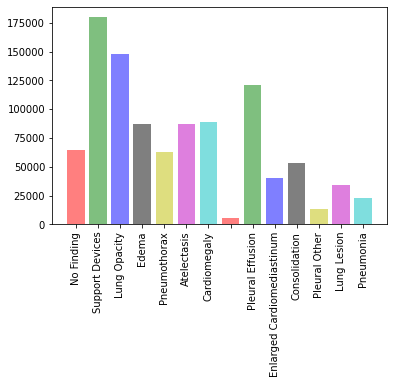

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

labels_count = Counter(label for chexpert_targets in oversampled_small_train_df['feature_string'] for label in chexpert_targets)
print(labels_count, list(labels_count.keys()))
x_pos = np.arange(len(labels_count.values()))
lbls = list.copy(list(labels_count.keys()))

plt.bar(x_pos, labels_count.values(), align='center', alpha=0.5 , color=['r', 'g', 'b', 'k', 'y', 'm', 'c'])
plt.xticks(x_pos, lbls, rotation='vertical')
plt.show()

In [12]:
len(oversampled_small_train_df)

366682

# Add covid data

In [13]:
train_covid_df = pd.read_csv("data_for_training/train_sigmoid.csv")
val_covid_df = pd.read_csv("data_for_training/test_sigmoid.csv")

import ast
def fstring_covid(row):
    temp = []
    temp2 = ast.literal_eval(row['Label'])
    for k in temp2:
        temp.append(ast.literal_eval(k))
    temp3 = ["No Finding", "Lung Opacity", "Pneumonia", "Covid"]
    lab = temp3[np.argmax(np.array(temp2))]
    return [str(lab)]

train_covid_df['feature_string'] = train_covid_df.apply(fstring_covid,axis = 1).fillna('')
val_covid_df['feature_string'] = val_covid_df.apply(fstring_covid,axis = 1).fillna('')

train_covid_df = np.array(train_covid_df)
val_covid_df = np.array(val_covid_df)

temp_train = []
temp_val = []

valHealtyCount = 0
for k in train_covid_df:
    l1 = k[-1]
    if 'Opacity' not in l1[0]:      
        if 'No Finding' in l1[0] and valHealtyCount < 6000:
            #print(l1[0], valHealtyCount)
            temp_train.append(k)
            valHealtyCount += 1
        elif 'Covid' in l1[0] or 'Pneumonia' in l1[0]:
            temp_train.append(k)

valHealtyCount = 0
for k in val_covid_df:
    l1 = k[-1]
    if 'Opacity' not in l1[0]:      
        if 'No Finding' in l1[0] and valHealtyCount < 550:
            #print(l1[0], valHealtyCount)
            temp_val.append(k)
            valHealtyCount += 1
        elif 'Covid' in l1[0] or 'Pneumonia' in l1[0]:
            temp_val.append(k)
        

train_covid_df = np.array(temp_train)
val_covid_df = np.array(temp_val)

train_covid_df = pd.DataFrame({'Path': train_covid_df[:, 0], 'feature_string': train_covid_df[:, 2]})
val_covid_df = pd.DataFrame({'Path': val_covid_df[:, 0], 'feature_string': val_covid_df[:, 2]})

Counter({'No Finding': 6000, 'Covid': 3074, 'Pneumonia': 1144}) ['Covid', 'Pneumonia', 'No Finding']


([<matplotlib.axis.XTick at 0x7fb3ee196e20>,
 [Text(0, 0, 'Covid'), Text(1, 0, 'Pneumonia'), Text(2, 0, 'No Finding')])

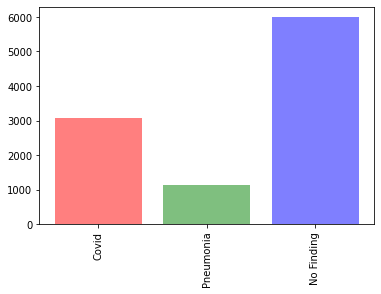

In [14]:
from collections import Counter
import matplotlib.pyplot as plt

labels_count = Counter(label for chexpert_targets in train_covid_df['feature_string'] for label in chexpert_targets)
print(labels_count, list(labels_count.keys()))
x_pos = np.arange(len(labels_count.values()))
lbls = list.copy(list(labels_count.keys()))

plt.bar(x_pos, labels_count.values(), align='center', alpha=0.5 , color=['r', 'g', 'b', 'k', 'y', 'm', 'c'])
plt.xticks(x_pos, lbls, rotation='vertical')

# Oversample Covid Classes

In [15]:
#oversampled_small_train_df
oversampled_small_train_covid_df = train_covid_df.copy()
print(len(oversampled_small_train_covid_df))
y_labels = list(train_covid_df['feature_string'])
_to_oversample = ['Covid', 'Pneumonia']

add = 1
for ctr, k in enumerate(y_labels):
    for l in k:
        if l in _to_oversample:
            if l == 'Pneumonia':
                for f in range(5):
                    oversampled_small_train_covid_df.loc[len(oversampled_small_train_covid_df)+add]=list(train_covid_df.iloc[ctr])
                    add += 1
                    
            elif l == 'Covid':
                for f in range(2):
                    oversampled_small_train_covid_df.loc[len(oversampled_small_train_covid_df)+add]=list(train_covid_df.iloc[ctr])
                    add += 1
            
            #print(add, len(oversampled_small_train_df))

10218


Counter({'Covid': 9222, 'Pneumonia': 6864, 'No Finding': 6000}) ['Covid', 'Pneumonia', 'No Finding']


([<matplotlib.axis.XTick at 0x7fb3edf4c3a0>,
 [Text(0, 0, 'Covid'), Text(1, 0, 'Pneumonia'), Text(2, 0, 'No Finding')])

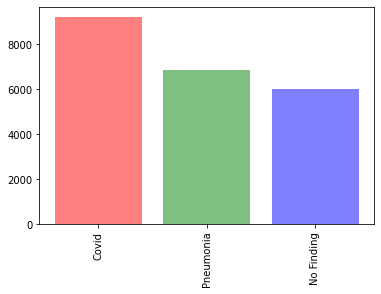

In [16]:
from collections import Counter
import matplotlib.pyplot as plt

labels_count = Counter(label for chexpert_targets in oversampled_small_train_covid_df['feature_string'] for label in chexpert_targets)
print(labels_count, list(labels_count.keys()))
x_pos = np.arange(len(labels_count.values()))
lbls = list.copy(list(labels_count.keys()))

plt.bar(x_pos, labels_count.values(), align='center', alpha=0.5 , color=['r', 'g', 'b', 'k', 'y', 'm', 'c'])
plt.xticks(x_pos, lbls, rotation='vertical')

# Combining Datasets

In [17]:
# Covid: oversampled_small_train_covid_df, val_covid_df
# Chexpert: oversampled_small_train_df, val_df

oversampled_small_train_df = oversampled_small_train_df[['Path', 'feature_string']]
val_df = val_df[['Path', 'feature_string']]

In [18]:
covid_chexpert_train_df = oversampled_small_train_df.append(oversampled_small_train_covid_df, ignore_index=True)
covid_chexpert_val_df = val_df.append(val_covid_df, ignore_index=True)

Counter({'Support Devices': 179841, 'Lung Opacity': 148282, 'Pleural Effusion': 120918, 'Cardiomegaly': 89371, 'Edema': 87312, 'Atelectasis': 86919, 'No Finding': 70410, 'Pneumothorax': 63281, 'Consolidation': 53530, 'Enlarged Cardiomediastinum': 40443, 'Lung Lesion': 34046, 'Pneumonia': 29580, 'Pleural Other': 13513, 'Covid': 9222, '': 5254}) ['No Finding', 'Support Devices', 'Lung Opacity', 'Edema', 'Pneumothorax', 'Atelectasis', 'Cardiomegaly', '', 'Pleural Effusion', 'Enlarged Cardiomediastinum', 'Consolidation', 'Pleural Other', 'Lung Lesion', 'Pneumonia', 'Covid']


([<matplotlib.axis.XTick at 0x7fb3edf08d30>,
 [Text(0, 0, 'No Finding'),
  Text(1, 0, 'Support Devices'),
  Text(2, 0, 'Lung Opacity'),
  Text(3, 0, 'Edema'),
  Text(4, 0, 'Pneumothorax'),
  Text(5, 0, 'Atelectasis'),
  Text(6, 0, 'Cardiomegaly'),
  Text(7, 0, ''),
  Text(8, 0, 'Pleural Effusion'),
  Text(9, 0, 'Enlarged Cardiomediastinum'),
  Text(10, 0, 'Consolidation'),
  Text(11, 0, 'Pleural Other'),
  Text(12, 0, 'Lung Lesion'),
  Text(13, 0, 'Pneumonia'),
  Text(14, 0, 'Covid')])

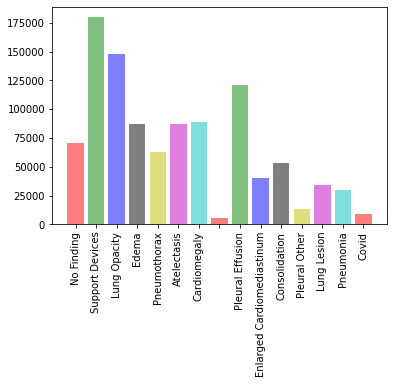

In [19]:
from collections import Counter
import matplotlib.pyplot as plt

labels_count = Counter(label for chexpert_targets in covid_chexpert_train_df['feature_string'] for label in chexpert_targets)
print(labels_count, list(labels_count.keys()))
x_pos = np.arange(len(labels_count.values()))
lbls = list.copy(list(labels_count.keys()))

plt.bar(x_pos, labels_count.values(), align='center', alpha=0.5 , color=['r', 'g', 'b', 'k', 'y', 'm', 'c'])
plt.xticks(x_pos, lbls, rotation='vertical')

# Save Dataframes

In [20]:
covid_chexpert_train_df.to_pickle("covid_chexpert_train_df_15cls_large.pkl")
covid_chexpert_val_df.to_pickle("covid_chexpert_val_df_15cls_large.pkl")

In [1]:
import pandas as pd

covid_chexpert_train_df = pd.read_pickle("covid_chexpert_train_df_15cls_large.pkl")
covid_chexpert_val_df = pd.read_pickle("covid_chexpert_val_df_15cls_large.pkl")

In [2]:
covid_chexpert_val_df

Path  \
0     CheXpert-v1.0-small/valid/patient64541/study1/...   
1     CheXpert-v1.0-small/valid/patient64542/study1/...   
2     CheXpert-v1.0-small/valid/patient64542/study1/...   
3     CheXpert-v1.0-small/valid/patient64543/study1/...   
4     CheXpert-v1.0-small/valid/patient64544/study1/...   
...                                                 ...   
1522  ./COVID-19_Radiography_Dataset/Normal/Normal-4...   
1523  ./COVID-19_Radiography_Dataset/Normal/Normal-4...   
1524  ./COVID-19_Radiography_Dataset/Normal/Normal-4...   
1525  ./COVID-19_Radiography_Dataset/Normal/Normal-4...   
1526  ./COVID-19_Radiography_Dataset/Normal/Normal-4...   

                                         feature_string  
0     [Cardiomegaly, Enlarged Cardiomediastinum, Lun...  
1                                     [Support Devices]  
2                                     [Support Devices]  
3     [Edema, Enlarged Cardiomediastinum, Lung Opacity]  
4                                          [No Finding]  
...                                                 ...  
1522                                       [No Finding]  
1523                                       [No Finding]  
1524                                       [No Finding]  
1525                                       [No Finding]  
1526                                       [No Finding]  

[1527 rows x 2 columns]

# Creating datasets

In [3]:
from keras.preprocessing import image
datagen2=image.ImageDataGenerator(rescale=1./255, 
                                 featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=5,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 validation_split = 0.1)
test_datagen=image.ImageDataGenerator(rescale=1./255)

In [4]:
train_generator=datagen2.flow_from_dataframe(dataframe=covid_chexpert_train_df, directory="/bigdisk/data/dataset/", 
                                            x_col="Path", y_col="feature_string", 
                                            seed = 42, class_mode="categorical", 
                                            target_size=(224,224), batch_size=32,
                                            #classes=['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion', 'No Finding'],
                                            subset = "training")

val_generator=test_datagen.flow_from_dataframe(dataframe=covid_chexpert_val_df, directory="/bigdisk/data/dataset/", 
                                            x_col="Path", y_col="feature_string", 
                                            seed = 42, class_mode="categorical", 
                                            target_size=(224,224), batch_size=32,
                                            #classes=['', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion', 'No Finding'],
                                            subset = "training")

Found 349892 validated image filenames belonging to 15 classes.
Found 1527 validated image filenames belonging to 15 classes.


In [4]:
train_generator.class_indices, val_generator.class_indices

({'': 0,
  'Atelectasis': 1,
  'Cardiomegaly': 2,
  'Consolidation': 3,
  'Covid': 4,
  'Edema': 5,
  'Enlarged Cardiomediastinum': 6,
  'Lung Lesion': 7,
  'Lung Opacity': 8,
  'No Finding': 9,
  'Pleural Effusion': 10,
  'Pleural Other': 11,
  'Pneumonia': 12,
  'Pneumothorax': 13,
  'Support Devices': 14},
 {'': 0,
  'Atelectasis': 1,
  'Cardiomegaly': 2,
  'Consolidation': 3,
  'Covid': 4,
  'Edema': 5,
  'Enlarged Cardiomediastinum': 6,
  'Lung Lesion': 7,
  'Lung Opacity': 8,
  'No Finding': 9,
  'Pleural Effusion': 10,
  'Pleural Other': 11,
  'Pneumonia': 12,
  'Pneumothorax': 13,
  'Support Devices': 14})

In [5]:
del train_generator
del datagen2
del test_datagen